In [108]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import cartopy.crs as ccrs
import gsw
from eofs.xarray import Eof
from scipy.fft import fft, fftfreq
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


from utils import *

In [2]:
ds_surface = load_surface_data()
print(f'Size of the dataset: {ds_surface.nbytes/1e9} GB')
ds_surface

Size of the dataset: 1.229445704 GB


<xarray.Dataset>
Dimensions:    (time: 252, latitude: 121, longitude: 1440)
Coordinates:
    depth      float32 ...
  * latitude   (latitude) float32 60.0 60.25 60.5 60.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2023-12-01
Data variables:
    S          (time, latitude, longitude) float32 ...
    T          (time, latitude, longitude) float32 ...
    SIC        (time, latitude, longitude) float32 ...
    SIT        (time, latitude, longitude) float32 ...
    U          (time, latitude, longitude) float32 ...
    V          (time, latitude, longitude) float32 ...
    SSH        (time, latitude, longitude) float32 ...
Attributes:
    history:      Creation 2023-October-31 12:55:11 GMT+0200
    Conventions:  CF-1.6
    institution:  Mercator Ocean
    title:        Monthly mean fields for product GLOBAL_MULTIYEAR_PHY_ENS_00...
    references:   http://marine.copernicus.eu
    contact:      servicedesk.cmems@mercator-ocean.eu
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    source:       Copernicus Marine Service
    producer:     CMEMS - Global Monitoring and Forecasting Centre

In [3]:
ds_atm = load_atm_data()
print(f'Size of the dataset: {ds_atm.nbytes/1e9} GB')
ds_atm

Size of the dataset: 2.810157224 GB


<xarray.Dataset>
Dimensions:    (time: 252, latitude: 121, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2023-12-01
  * latitude   (latitude) float64 60.0 60.25 60.5 60.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Data variables: (12/16)
    asn        (time, latitude, longitude) float32 ...
    rsn        (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
    sd         (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    ...         ...
    es         (time, latitude, longitude) float32 ...
    smlt       (time, latitude, longitude) float32 ...
    sf         (time, latitude, longitude) float32 ...
    sshf       (time, latitude, longitude) float32 ...
    slhf       (time, latitude, longitude) float32 ...
    ssr        (time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [19]:
ds = xr.merge([ds_surface, ds_atm])
print(f'Size of the dataset: {ds.nbytes/1e9} GB')
ds

Size of the dataset: 4.039588424 GB


<xarray.Dataset>
Dimensions:    (time: 252, latitude: 121, longitude: 1440)
Coordinates:
    depth      float32 ...
  * latitude   (latitude) float32 60.0 60.25 60.5 60.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2023-12-01
Data variables: (12/23)
    S          (time, latitude, longitude) float32 ...
    T          (time, latitude, longitude) float32 ...
    SIC        (time, latitude, longitude) float32 ...
    SIT        (time, latitude, longitude) float32 ...
    U          (time, latitude, longitude) float32 ...
    V          (time, latitude, longitude) float32 ...
    ...         ...
    es         (time, latitude, longitude) float32 ...
    smlt       (time, latitude, longitude) float32 ...
    sf         (time, latitude, longitude) float32 ...
    sshf       (time, latitude, longitude) float32 ...
    slhf       (time, latitude, longitude) float32 ...
    ssr        (time, latitude, longitude) float32 ...
Attributes:
    history:      Creation 2023-October-31 12:55:11 GMT+0200
    Conventions:  CF-1.6
    institution:  Mercator Ocean
    title:        Monthly mean fields for product GLOBAL_MULTIYEAR_PHY_ENS_00...
    references:   http://marine.copernicus.eu
    contact:      servicedesk.cmems@mercator-ocean.eu
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    source:       Copernicus Marine Service
    producer:     CMEMS - Global Monitoring and Forecasting Centre

In [88]:
variables_to_keep = [
    'T', 'sst', 't2m', 'msl', 'sd', 'SIT', 'u10', 'v10'
]

ds = ds[variables_to_keep].load()
print(f'Size of the dataset: {ds.nbytes/1e9} GB')

weights = np.cos(np.deg2rad(ds.latitude)) + ds.longitude * 0
weights = weights / weights.sum()
weights

Size of the dataset: 1.405079624 GB


<xarray.DataArray (latitude: 121, longitude: 1440)>
array([[ 1.1217119e-05,  1.1217119e-05,  1.1217119e-05, ...,
         1.1217119e-05,  1.1217119e-05,  1.1217119e-05],
       [ 1.1132239e-05,  1.1132239e-05,  1.1132239e-05, ...,
         1.1132239e-05,  1.1132239e-05,  1.1132239e-05],
       [ 1.1047148e-05,  1.1047148e-05,  1.1047148e-05, ...,
         1.1047148e-05,  1.1047148e-05,  1.1047148e-05],
       ...,
       [ 1.9577377e-07,  1.9577377e-07,  1.9577377e-07, ...,
         1.9577377e-07,  1.9577377e-07,  1.9577377e-07],
       [ 9.7888659e-08,  9.7888659e-08,  9.7888659e-08, ...,
         9.7888659e-08,  9.7888659e-08,  9.7888659e-08],
       [-9.8063170e-13, -9.8063170e-13, -9.8063170e-13, ...,
        -9.8063170e-13, -9.8063170e-13, -9.8063170e-13]], dtype=float32)
Coordinates:
    depth      float32 0.5058
  * latitude   (latitude) float32 60.0 60.25 60.5 60.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

In [ ]:
# Compute climatology
ds_climatology = ds.groupby('time.month').mean('time')

# Compute anomalies
ds_anomalies = ds.groupby('time.month') - ds_climatology


In [72]:
# Compute anomalies trends
trends_coefs = ds_anomalies.polyfit('time', 2)
ds_trends = xr.polyval(ds_anomalies.time, trends_coefs)
ds_trends = ds_trends.rename_vars({f'{var}_polyfit_coefficients': f'{var}' for var in ds.data_vars})

In [73]:
# Remove trends
ds_anomalies_detrended = ds_anomalies - ds_trends

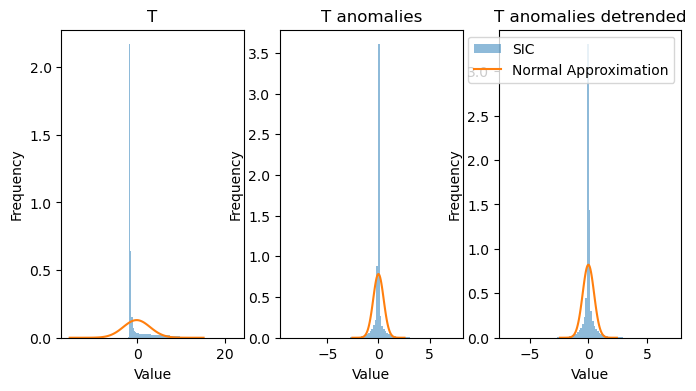

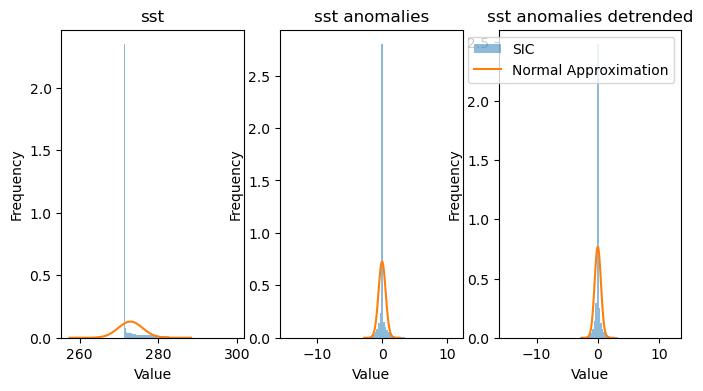

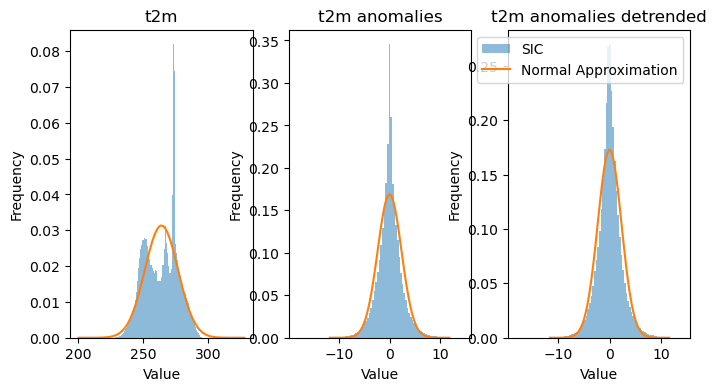

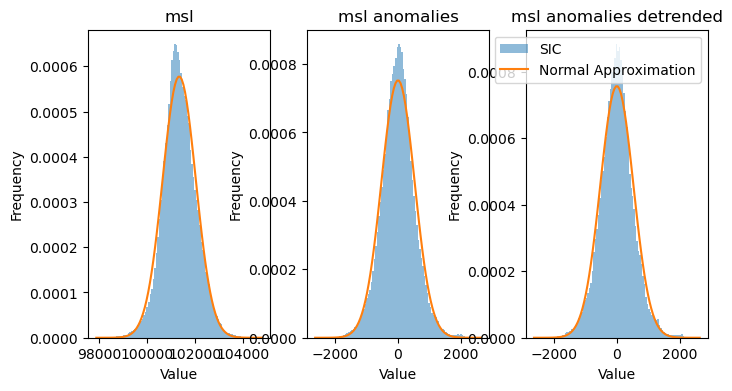

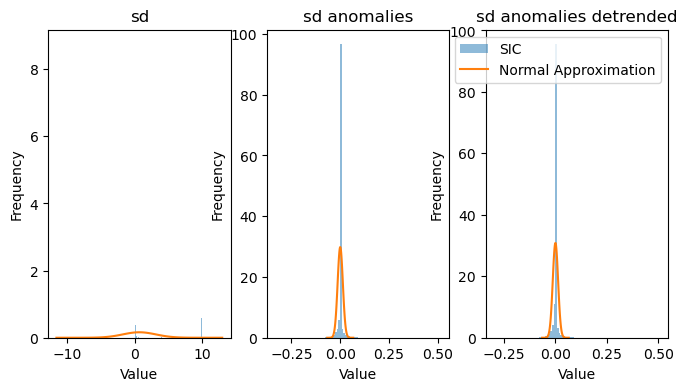

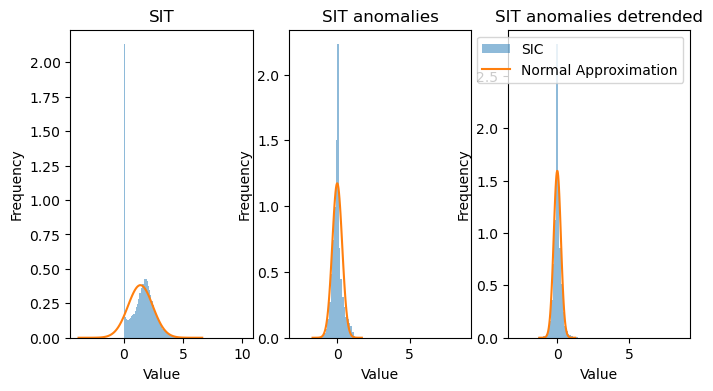

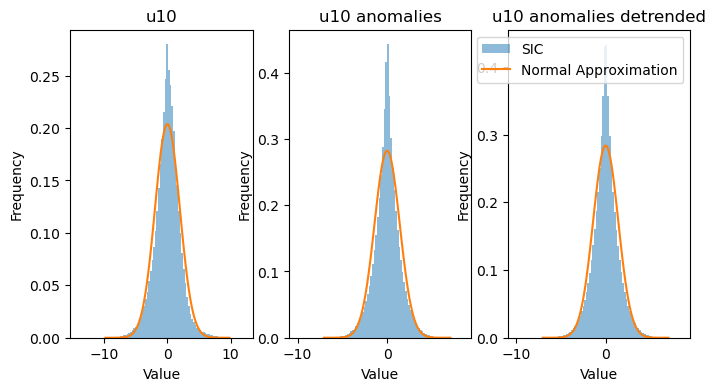

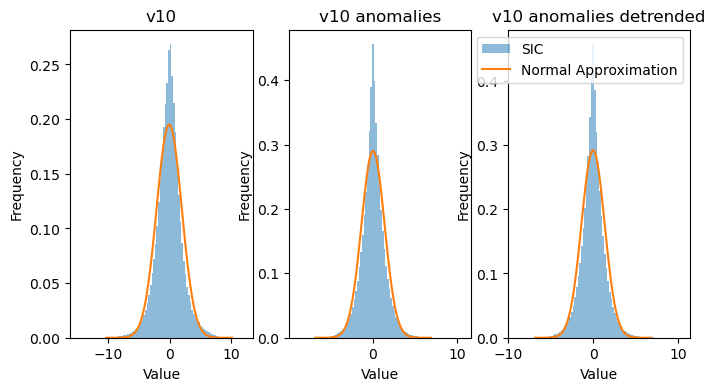

In [74]:
for var in ds_anomalies.data_vars:
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))

    ax = axs[0]
    all_values = ds[var].values.flatten()
    ax.hist(all_values, bins=100, alpha=0.5, label='SIC', density=True)
    mu, sigma = np.nanmean(all_values), np.nanstd(all_values)
    x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
    ax.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2)), label='Normal Approximation')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{var}')

    ax = axs[1]
    all_values = ds_anomalies[var].values.flatten()
    ax.hist(all_values, bins=100, alpha=0.5, label='SIC', density=True)
    mu, sigma = np.nanmean(all_values), np.nanstd(all_values)
    x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
    ax.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2)), label='Normal Approximation')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{var} anomalies')

    ax = axs[2]
    all_values = ds_anomalies_detrended[var].values.flatten()
    ax.hist(all_values, bins=100, alpha=0.5, label='SIC', density=True)
    mu, sigma = np.nanmean(all_values), np.nanstd(all_values)
    x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
    ax.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2)), label='Normal Approximation')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{var} anomalies detrended')

    plt.legend()
    plt.show()

In [75]:
def fast_eof_analysis(eof_solver):
    eof_solver.varianceFraction().plot(marker='o')
    plt.xlim(0, 20)
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(20, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})

    max_val = np.abs(eof_solver.eofs()[:3]).max()

    for i in range(3):
        ax = axs[i]
        ax.coastlines()
        ax.gridlines()
        pcm = ax.pcolormesh(
            ds_anomalies.longitude, 
            ds_anomalies.latitude, 
            eof_solver.eofs()[i], 
            transform=ccrs.PlateCarree(), 
            cmap=cmo.balance,
            norm=colors.Normalize(vmin=-max_val, vmax=max_val),
        )
        ax.set_title(f'EOF {i+1}')
    plt.colorbar(pcm, ax=axs, label='EOF amplitude', orientation='horizontal', shrink=0.8)
    plt.suptitle('Amplitude EOFs')
    plt.show()



    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    for i in range(3):
        ax.plot(eof_solver.pcs().time, eof_solver.pcs()[:, i], label=f'PC {i+1}')
    plt.legend()
    plt.title('PCs (time domain)')
    plt.show()


    # Number of sample points
    N = eof_solver.pcs().shape[0]
    # Sample spacing
    T = (eof_solver.pcs().time[1] - eof_solver.pcs().time[0]).values.astype('timedelta64[D]').astype(int) / 365.25

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    for i in range(3):
        yf = fft(eof_solver.pcs()[:, i].values)
        xf = fftfreq(N, T)[:N//2]
        ax.plot(xf, 2.0/N * np.abs(yf[:N//2]), label=f'PC {i+1}')

    ax.axvline(x=1, color='r', linestyle='--', label='f=1/year')
    plt.legend()
    plt.title('PCs (frequency domain)')
    plt.xlabel('Frequency [1/year]')
    plt.ylabel('Amplitude')
    #plt.xscale('log')
    #plt.yscale('log')
    plt.show()

In [99]:
solver = Eof(ds_anomalies_detrended['msl'], weights=weights)

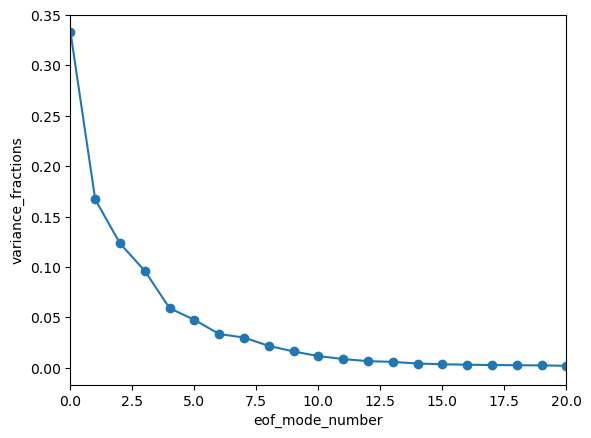

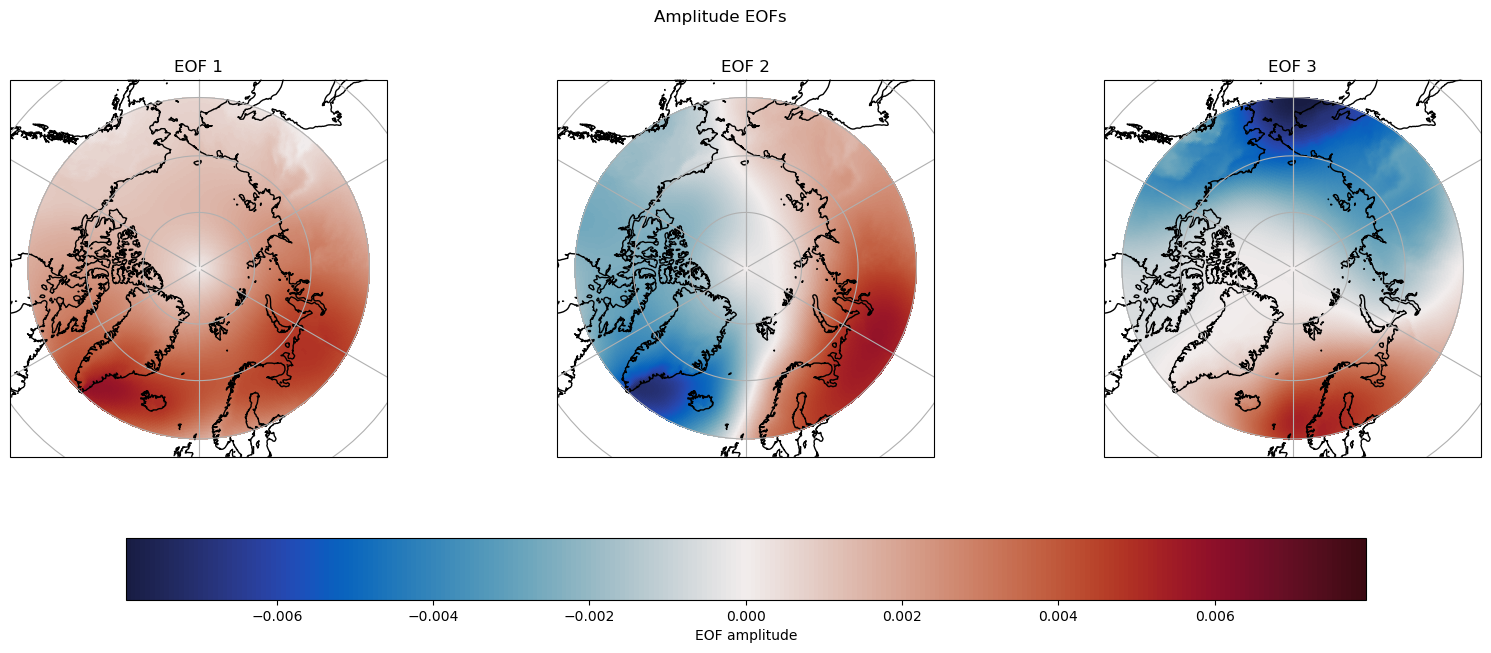

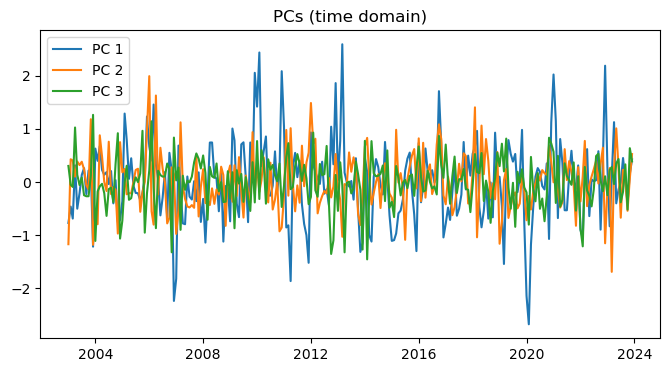

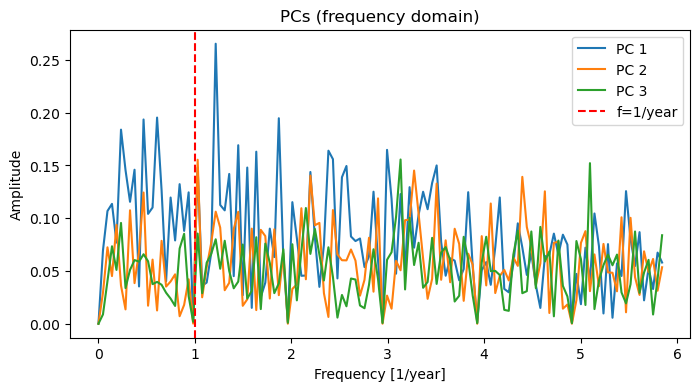

In [100]:
fast_eof_analysis(solver)

In [153]:
def get_climate_index():
    idx_names = ['NAO', 'AO', 'PDO', 'SOI']
    time = pd.date_range(start='2003-01-01', end='2023-12-01', freq='MS')

    dss = []
    

    for name in idx_names:
        df = pd.read_csv(f'data/{name}.csv', delim_whitespace=True, skiprows=0, names=['Year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
        df_melted = df.melt(id_vars=['Year'], var_name='Month', value_name='Value')
        df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))
        df_melted = df_melted.sort_values('Date').set_index('Date')
        df_melted = df_melted.drop(columns=['Year', 'Month'])
        
        ds = xr.Dataset.from_dataframe(df_melted).rename_dims({'Date': 'time'}).rename_vars({'Value': name, 'Date': 'time'})
        dss.append(ds)

    ds = xr.merge(dss)
    ds = ds.sel(time=slice('2003', '2023'))
    return ds



ds = get_climate_index()

/var/folders/ks/hg8011s52v95t9b4pdt4llsm0000gn/T/ipykernel_6346/645499039.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'data/{name}.csv', delim_whitespace=True, skiprows=0, names=['Year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
/var/folders/ks/hg8011s52v95t9b4pdt4llsm0000gn/T/ipykernel_6346/645499039.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'data/{name}.csv', delim_whitespace=True, skiprows=0, names=['Year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
/var/folders/ks/hg8011s52v95t9b4pdt4llsm0000gn/T/ipykernel_6346/645499039.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'data/{name}.csv', delim_whitespace=True, skiprows=0, na

In [151]:
ds

<xarray.Dataset>
Dimensions:  (time: 252)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2023-12-01
Data variables:
    NAO      (time) float64 -0.32 0.26 -0.07 -0.34 0.06 ... -0.28 -1.7 -0.47 1.7
    AO       (time) float64 -0.988 -0.357 -0.188 0.224 ... 0.535 0.097 1.51
    PDO      (time) float64 2.09 1.75 1.51 1.18 0.89 ... nan nan nan nan nan
    SOI      (time) float64 -0.3 -1.1 -0.5 -0.2 -0.5 ... -2.1 -0.8 -1.3 -0.4

In [ ]:
import pandas as pd

df = pd.read_csv('data/AO.csv', delim_whitespace=True, skiprows=0, names=['Year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
df

df_melted = df.melt(id_vars=['Year'], var_name='Month', value_name='Value')
df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))
df_melted = df_melted.sort_values('Date').set_index('Date')
df_melted = df_melted.drop(columns=['Year', 'Month'])
df_melted

/var/folders/ks/hg8011s52v95t9b4pdt4llsm0000gn/T/ipykernel_6346/3688453959.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('data/AO.csv', delim_whitespace=True, skiprows=0, names=['Year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


,Value
Date,
1979-01-01,0.209
1979-02-01,0.356
1979-03-01,0.899
1979-04-01,0.678
1979-05-01,0.724
...,...
2024-08-01,-2.150
2024-09-01,0.098
2024-10-01,-0.567
